Temperature :  [10.1 10.3 11.5 ... 22.2 22.5 21.9]
Total Entries :  14775


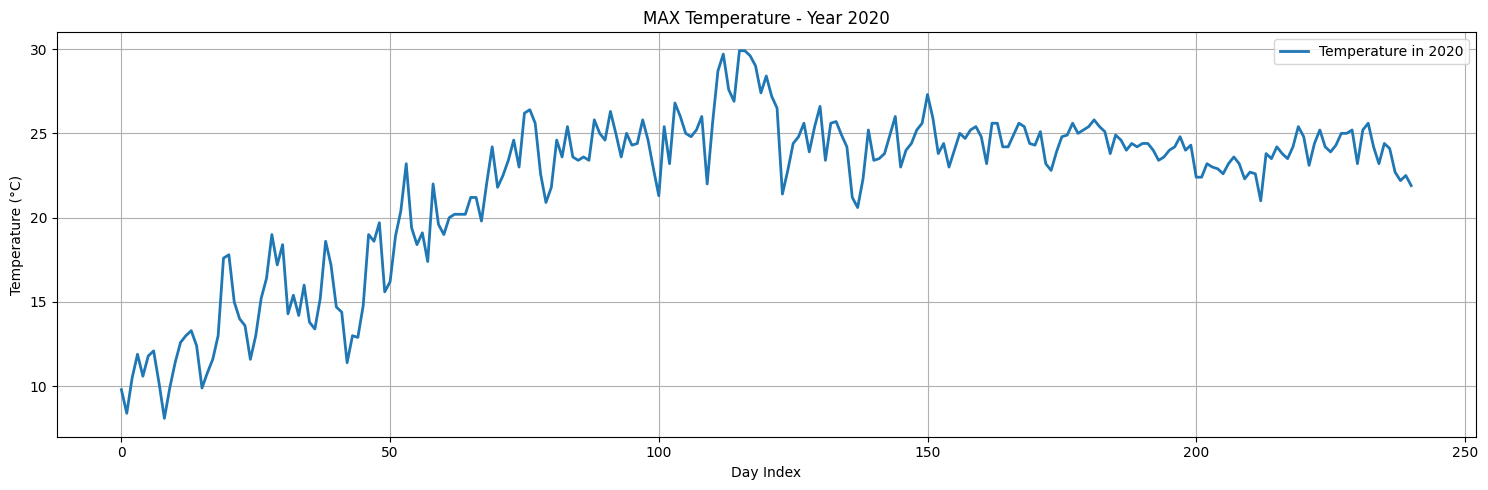

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv('/content/bhopal.csv')  # Replace with your file path
temp = df['MAX']
original_max = temp.copy()

# print imp things
print ("Temperature : ", original_max.values)
print ("Total Entries : ", len(original_max))

# Filter last year's data
last_year = df['INDEX'].max()
last_year_data = df[df['INDEX'] == last_year]

# print (last_year_data)

# Extract MAX temperatures for last year
temp_last_year = last_year_data['MAX'].values

# Plot the graph
plt.figure(figsize=(15, 5))
plt.plot(temp_last_year, label=f'Temperature in {last_year}', linewidth=2)
plt.title(f'MAX Temperature - Year {last_year}')
plt.xlabel('Day Index')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Temperature :           [10.1 10.3 11.5 ... 22.2 22.5 21.9]
Masked Temperature :    [10.1 10.3 11.5 ... 22.2  nan 21.9]
Observed Temperature :  [ True  True  True ...  True False  True]

Missing Values Count:  1498


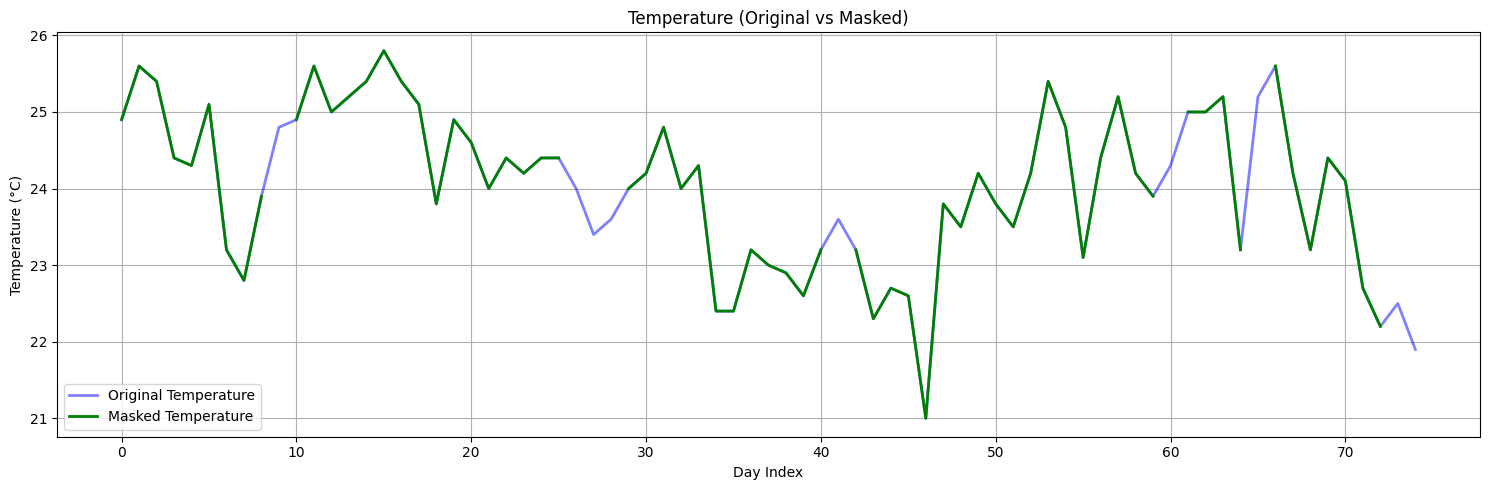

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Introduce missing values
def introduce_missing(data, missing_ratio=0.1, seed=42):
    np.random.seed(seed)
    data = data.copy()
    mask = np.ones(len(data), dtype=bool)
    indices = np.random.choice(len(data), int(missing_ratio * len(data)), replace=False)
    mask[indices] = False
    data[~mask] = np.nan
    return data, mask

masked_temp, observed_mask = introduce_missing(temp, missing_ratio=0.1)

# print (masked_temp)
# print (observed_mask)
print ("Temperature :          ", original_max.values)
print ("Masked Temperature :   ", masked_temp.values)
print ("Observed Temperature : ", observed_mask)

# # Assuming 'df' is your DataFrame and 'column_name' is the column you want to check
nan_count = np.isnan(masked_temp).sum()
print("\nMissing Values Count: ", nan_count)
# print(len(masked_temp))

# # Plot both graphs
plt.figure(figsize=(15, 5))
plt.plot(temp[14700: ].values, label='Original Temperature', color='blue', alpha=0.5, linewidth=2)
plt.plot(masked_temp[14700: ].values, label='Masked Temperature', color='green', linewidth=2)
plt.title(f'Temperature (Original vs Masked)')
plt.xlabel('Day Index')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# masked_max is already a numpy array, so directly reshape it
scaled_data = scaler.fit_transform(masked_temp.values.reshape(-1, 1))

class RNNImputer(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h, _ = self.rnn(x)
        out = self.fc(h)
        return out

print ("Model Generated")

Model Generated


In [ ]:
def prepare_sequences(data, window_size=10):
    X, Y = [], []
    for i in range(len(data) - window_size):
        if not np.isnan(data[i+window_size]):
            seq = data[i:i+window_size]
            if np.isnan(seq).any():
                continue
            X.append(seq)
            Y.append(data[i+window_size])
    return np.array(X), np.array(Y)

window_size = 30
seq_data = scaled_data.flatten()
X_train, Y_train = prepare_sequences(seq_data, window_size)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(-1)

print ("Training Dataset Generated")

Training Dataset Generated


In [ ]:
model = RNNImputer()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print ("Training Resuts : ")

epochs = 50
for epoch in range(epochs):
    model.train()
    output = model(X_train)
    loss = criterion(output[:, -1], Y_train.squeeze())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Training Resuts : 
Epoch 0, Loss: 0.7072


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([496])) that is different to the input size (torch.Size([496, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10, Loss: 0.0426
Epoch 20, Loss: 0.0213
Epoch 30, Loss: 0.0218
Epoch 40, Loss: 0.0215


In [ ]:
def forward_impute(data, model, window_size):
    data = data.copy()
    model.eval()
    with torch.no_grad():
        for i in range(len(data)):
            if np.isnan(data[i]):
                if i < window_size:
                    continue  # Not enough history
                input_seq = data[i - window_size:i]
                if np.isnan(input_seq).any():
                    continue
                input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
                pred = model(input_tensor)
                data[i] = pred[0, -1].item()
    return data

imputed_scaled = forward_impute(seq_data, model, window_size)
imputed_values = scaler.inverse_transform(imputed_scaled.reshape(-1, 1)).flatten()

print ("Imputed Temperature : ", imputed_values)


Imputed Temperature :  [10.1       10.3       11.5       ... 22.2       21.0239009 21.9      ]


MAE: 4.175, 
RMSE: 5.151


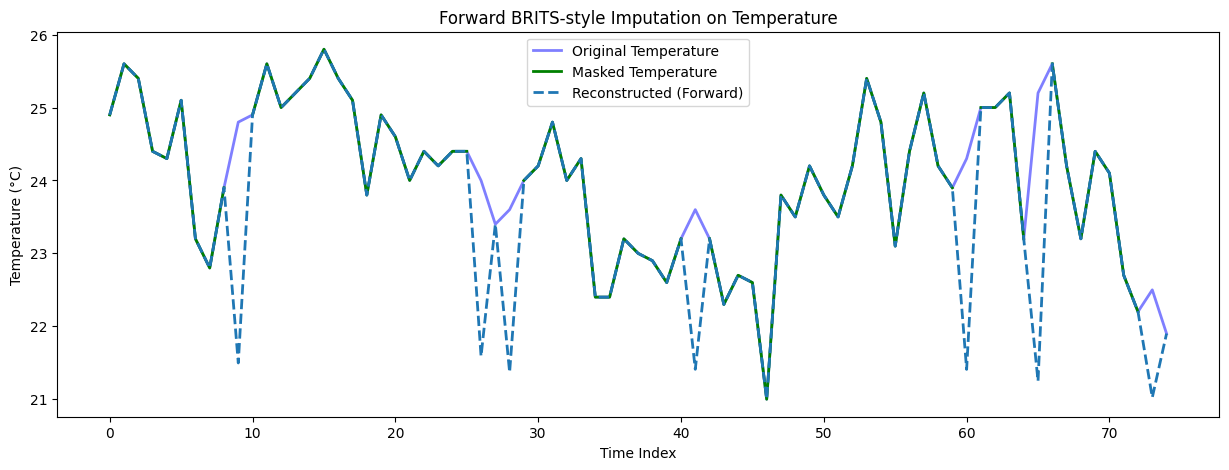

In [ ]:
# Replace only the missing positions
reconstructed = original_max.copy()
reconstructed[~observed_mask] = imputed_values[~observed_mask]


# Compare Imputed vs Original (only for masked positions)
true_vals = original_max[~observed_mask]
pred_vals = reconstructed[~observed_mask]

mae = np.mean(np.abs(true_vals - pred_vals))
rmse = np.sqrt(np.mean((true_vals - pred_vals)**2))
print(f'MAE: {mae:.3f}, \nRMSE: {rmse:.3f}')

# Plot
plt.figure(figsize=(15, 5))
plt.plot(temp[14700: ].values, label='Original Temperature', color='blue', alpha=0.5, linewidth=2)
plt.plot(masked_temp[14700: ].values, label='Masked Temperature', color='green', linewidth=2)
plt.plot(reconstructed[14700: ].values, label='Reconstructed (Forward)', linestyle='dashed', linewidth=2)
plt.legend()
plt.title("Forward BRITS-style Imputation on Temperature")
plt.xlabel("Time Index")
plt.ylabel("Temperature (°C)")
plt.show()


In [ ]:
def backward_impute(data, model, window_size):
    data = data.copy()[::-1]  # Reverse the sequence
    model.eval()
    with torch.no_grad():
        for i in range(len(data)):
            if np.isnan(data[i]):
                if i < window_size:
                    continue  # Not enough future context (since reversed)
                input_seq = data[i - window_size:i]
                if np.isnan(input_seq).any():
                    continue
                # Create a copy of input_seq to avoid negative strides
                input_seq = input_seq.copy()
                input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
                pred = model(input_tensor)
                data[i] = pred[0, -1].item()

    return data[::-1]  # Reverse back to original order


# Impute using backward direction
imputed_scaled_back = backward_impute(seq_data, model, window_size)
imputed_values_back = scaler.inverse_transform(imputed_scaled_back.reshape(-1, 1)).flatten()

# print (len(imputed_values_back))

In [ ]:


# Replace only the missing positions
reconstructed_back = original_max.copy()
reconstructed_back[~observed_mask] = imputed_values_back[~observed_mask]

# Evaluation
true_vals_back = original_max[~observed_mask]
pred_vals_back = reconstructed_back[~observed_mask]

mae_back = np.mean(np.abs(true_vals_back - pred_vals_back))
rmse_back = np.sqrt(np.mean((true_vals_back - pred_vals_back)**2))
print(f'[Backward] \nMAE: {mae_back:.3f}, \nRMSE: {rmse_back:.3f}')


[Backward] 
MAE: 4.158, 
RMSE: 5.148


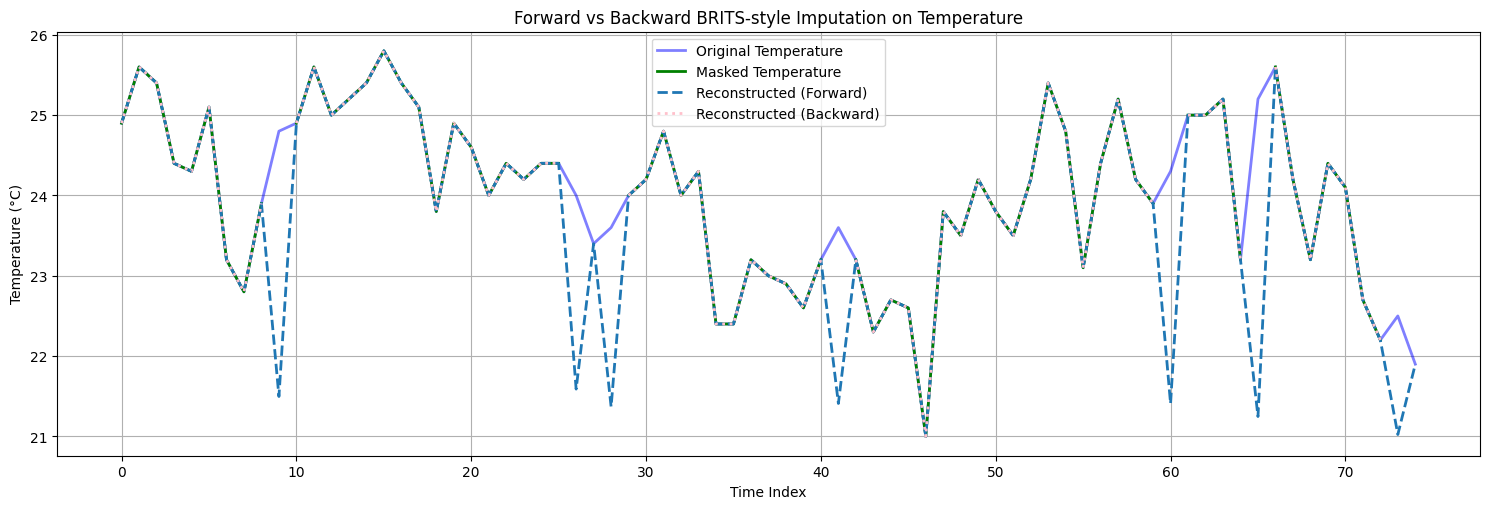

In [ ]:

# Plot
plt.figure(figsize=(15, 5))
plt.plot(temp[14700: ].values, label='Original Temperature', color='blue', alpha=0.5, linewidth=2)
plt.plot(masked_temp[14700: ].values, label='Masked Temperature', color='green', linewidth=2)
plt.plot(reconstructed[14700: ].values, label='Reconstructed (Forward)', linestyle='dashed', linewidth=2)
plt.plot(reconstructed_back[14700: ].values, label='Reconstructed (Backward)', linestyle=':', color='pink', linewidth=2)

# # Highlight missing points from the original series
# plt.scatter(np.where(~observed_mask)[0], original_max[14700: ][~observed_mask],
#             color='red', label='Missing Values', s=10)

plt.xlabel("Time Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.title("Forward vs Backward BRITS-style Imputation on Temperature")
plt.show()



Meta-model MAE: 1.457, RMSE: 2.012


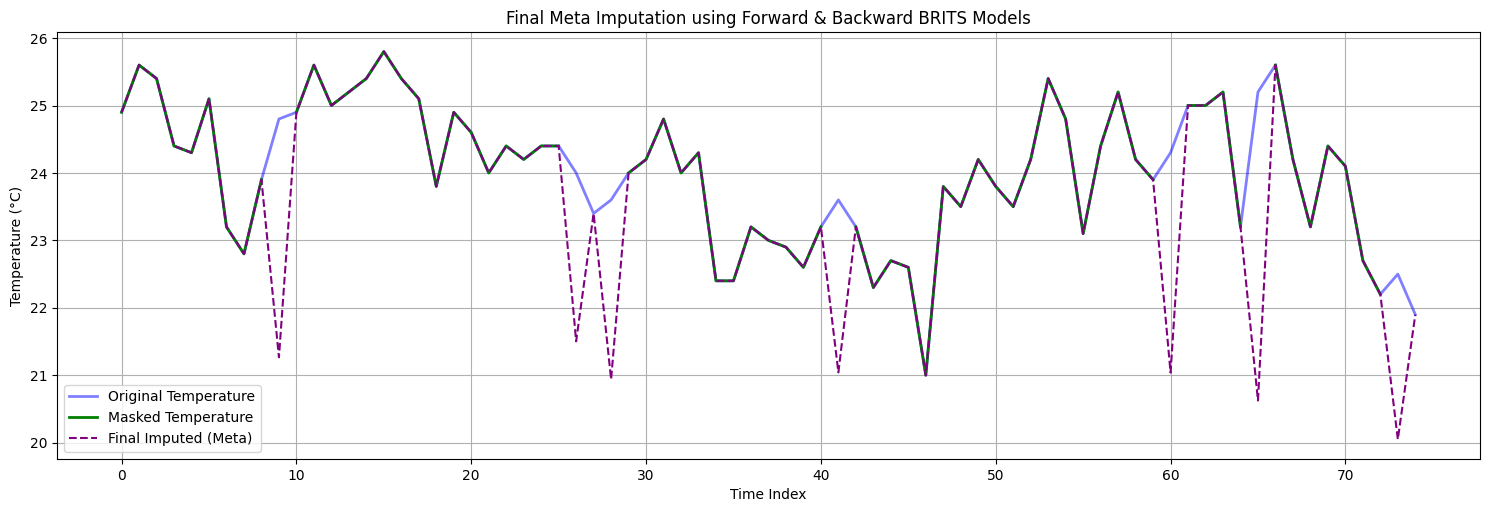

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

# Prepare training data for meta-model (only where values were originally missing)
missing_indices = np.where(~observed_mask)[0]


# Use full imputed values from both models
X_meta = np.vstack([
    imputed_values[missing_indices],
    imputed_values_back[missing_indices]
]).T  # shape: (num_missing, 2)


y_meta = original_max.iloc[missing_indices]  # True values at missing positions

# ----> Remove rows with NaN values in y_meta <----
# Get indices of rows without NaN values in y_meta
valid_indices = y_meta.notna().values

# Filter X_meta and y_meta to keep only valid rows
X_meta = X_meta[valid_indices]
y_meta = y_meta[valid_indices]
# <---- end of change ---->

# Impute remaining NaNs in X_meta using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # or other strategies like 'median'
X_meta = imputer.fit_transform(X_meta)

# Train meta-model
meta_model = LinearRegression()
meta_model.fit(X_meta, y_meta)

# Predict final values
final_preds = meta_model.predict(X_meta)

# Evaluation
meta_mae = mean_absolute_error(y_meta, final_preds)
meta_rmse = np.sqrt(mean_squared_error(y_meta, final_preds))
print(f"Meta-model MAE: {meta_mae:.3f}, RMSE: {meta_rmse:.3f}")

# Construct full series with meta predictions
final_reconstructed = original_max.copy()
# ----> Use .iloc to assign values based on position <----
final_reconstructed.iloc[missing_indices[valid_indices]] = final_preds
# <---- end of change ---->

# Plot
# plt.figure(figsize=(15, 5))
# plt.plot(original_max.values, label='Original', color='blue', linewidth=1)
# plt.plot(final_reconstructed.values, label='Final Imputed (Meta)', linestyle='dashed', color='green')
# plt.scatter(missing_indices[valid_indices], y_meta, color='red', label='Missing Points', s=10)


# plt.title("Final Meta Imputation using Forward & Backward BRITS Models")
# plt.xlabel("Time Index")
# plt.ylabel("Temperature (°C)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Plot
plt.figure(figsize=(15, 5))
plt.plot(temp[14700: ].values, label='Original Temperature', color='blue', alpha=0.5, linewidth=2)
plt.plot(masked_temp[14700: ].values, label='Masked Temperature', color='green', linewidth=2)
plt.plot(final_reconstructed[14700: ].values, label='Final Imputed (Meta)', linestyle='dashed', color='purple')


# # Highlight missing points from the original series
# plt.scatter(np.where(~observed_mask)[0], original_max[14700: ][~observed_mask],
#             color='red', label='Missing Values', s=10)

plt.xlabel("Time Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.title("Final Meta Imputation using Forward & Backward BRITS Models")
plt.show()
